In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Display the first few rows
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,is_default
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
3,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
4,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
#df = df[df['is_default'].notnull()]
features = ['int_rate', 'fico_range_low', 'annual_inc', 'loan_amnt', 'dti']
print(df[features].isnull().sum())


int_rate            0
fico_range_low      0
annual_inc          4
loan_amnt           0
dti               374
dtype: int64


for col in features:
    df[f'{col}_missing'] = df[col].isnull().astype(int)

This code may be used later to flag unites that have missing values before the values are mutated to add an aditional feature for pattern recognition. Maybe the missing data tells us more than if it were there. 


In [14]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='median')

X = imputer.fit_transform(df[features])
y = df['is_default'].values


In [26]:
print(type(X))  # Confirm it's a NumPy array
print(X.shape)  # Check dimensions (rows, columns)
print(X[:5])    # Preview first 5 rows


<class 'numpy.ndarray'>
(1348099, 5)
[[1.39900e+01 6.75000e+02 5.50000e+04 3.60000e+03 5.91000e+00]
 [1.19900e+01 7.15000e+02 6.50000e+04 2.47000e+04 1.60600e+01]
 [1.07800e+01 6.95000e+02 6.30000e+04 2.00000e+04 1.07800e+01]
 [2.24500e+01 6.95000e+02 1.04433e+05 1.04000e+04 2.53700e+01]
 [1.34400e+01 6.90000e+02 3.40000e+04 1.19500e+04 1.02000e+01]]


In [28]:
X_df = pd.DataFrame(X, columns=features)
print(X_df.head())  # Check the first few rows


   int_rate  fico_range_low  annual_inc  loan_amnt    dti
0     13.99           675.0     55000.0     3600.0   5.91
1     11.99           715.0     65000.0    24700.0  16.06
2     10.78           695.0     63000.0    20000.0  10.78
3     22.45           695.0    104433.0    10400.0  25.37
4     13.44           690.0     34000.0    11950.0  10.20


In [30]:
print(X_df.isnull().sum())  # Should all be zero


int_rate          0
fico_range_low    0
annual_inc        0
loan_amnt         0
dti               0
dtype: int64


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89    323622
           1       0.50      0.06      0.10     80808

    accuracy                           0.80    404430
   macro avg       0.65      0.52      0.49    404430
weighted avg       0.74      0.80      0.73    404430

ROC AUC: 0.692173545375545


So, not too good. It is good at predicting nondefault but terrible at predicting defaults. This is most likely due to the inbalance in the class distribution.
Now I will balance the class. 

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75    323622
           1       0.31      0.61      0.41     80808

    accuracy                           0.65    404430
   macro avg       0.59      0.64      0.58    404430
weighted avg       0.76      0.65      0.68    404430

ROC AUC: 0.6919548914393594


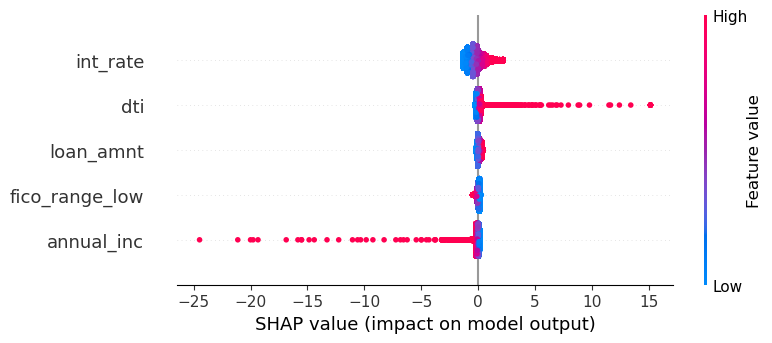

In [48]:
import shap

explainer = shap.Explainer(model, X_resampled, feature_names=X_df.columns)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values)


Below is the report for the first bower in the dataset, id=0.

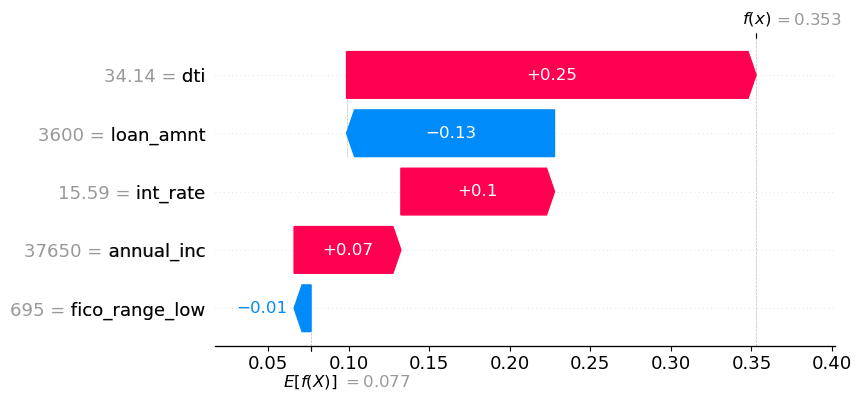

In [50]:
shap.plots.waterfall(shap_values[0])


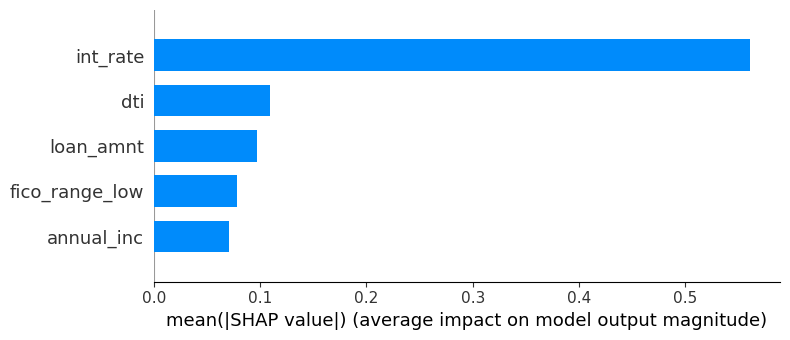

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
